Epoch 1/10 - Avg Loss: 0.0221
Epoch 2/10 - Avg Loss: 0.0192
Epoch 3/10 - Avg Loss: 0.0197
Epoch 4/10 - Avg Loss: 0.0189
Epoch 5/10 - Avg Loss: 0.0173
Epoch 6/10 - Avg Loss: 0.0148
Epoch 7/10 - Avg Loss: 0.0080
Epoch 8/10 - Avg Loss: 0.0031
Epoch 9/10 - Avg Loss: 0.0015
Epoch 10/10 - Avg Loss: 0.0006

üìä Evaluation Metrics:
MAE  = 0.0105
RMSE = 0.0133
R¬≤   = 0.9727


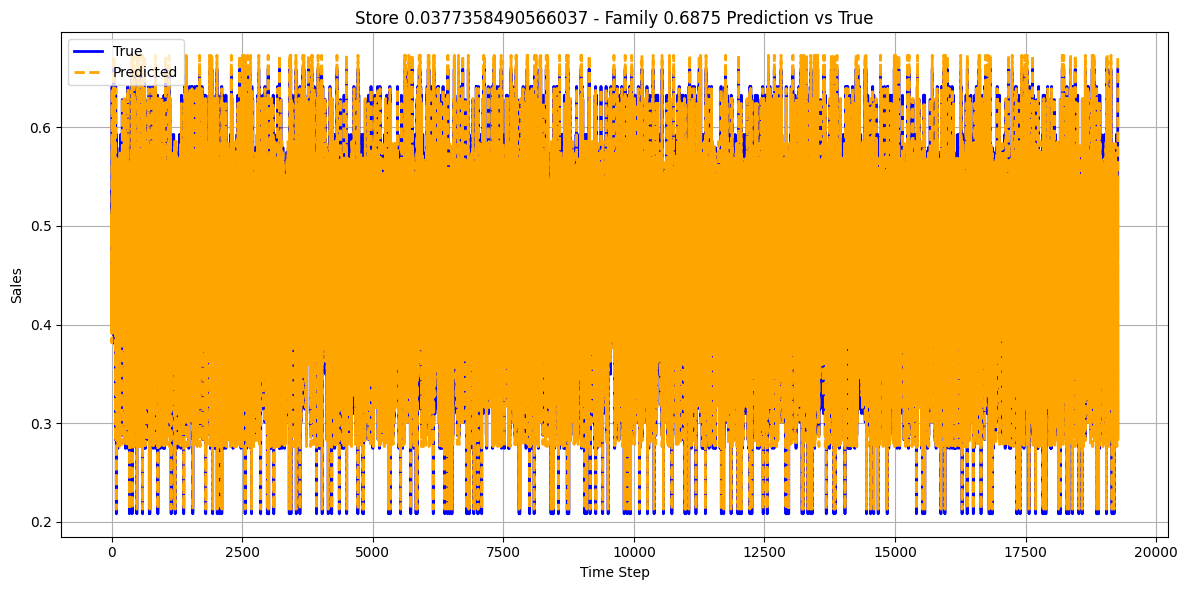

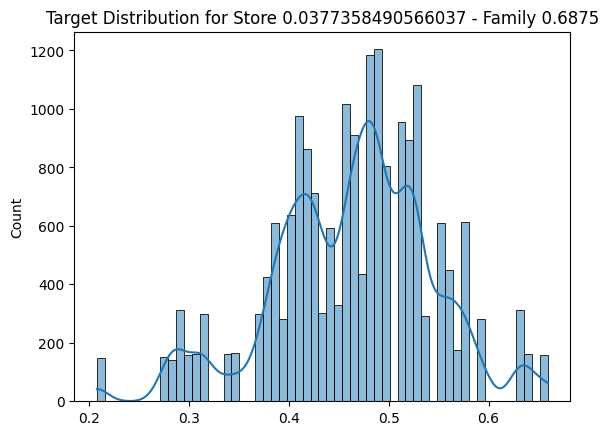

C:\Users\admin\AppData\Local\Temp\ipykernel_6460\3421209038.py:192: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


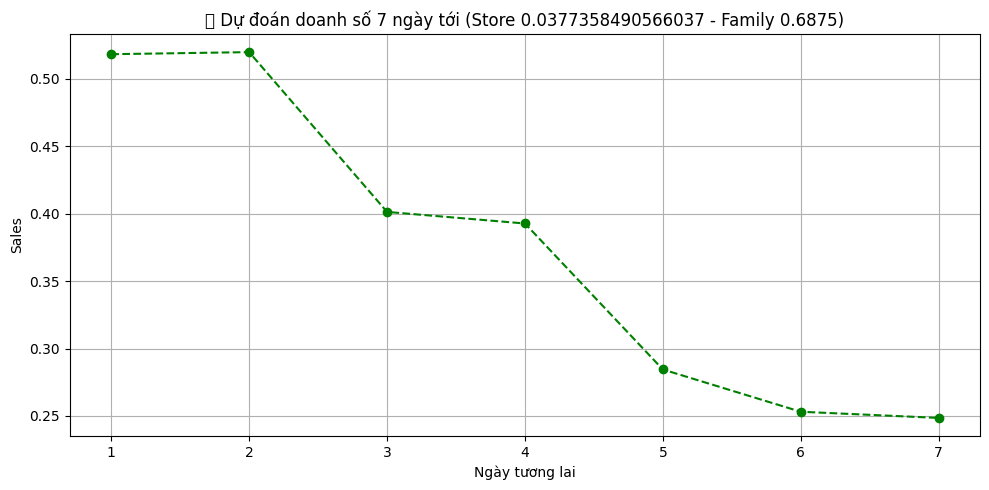

C:\Users\admin\AppData\Local\Temp\ipykernel_6460\3421209038.py:245: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()



üîÆ D·ª± ƒëo√°n 7 ng√†y t·ªõi:
Ng√†y +1: 0.52
Ng√†y +2: 0.52
Ng√†y +3: 0.40
Ng√†y +4: 0.39
Ng√†y +5: 0.28
Ng√†y +6: 0.25
Ng√†y +7: 0.25


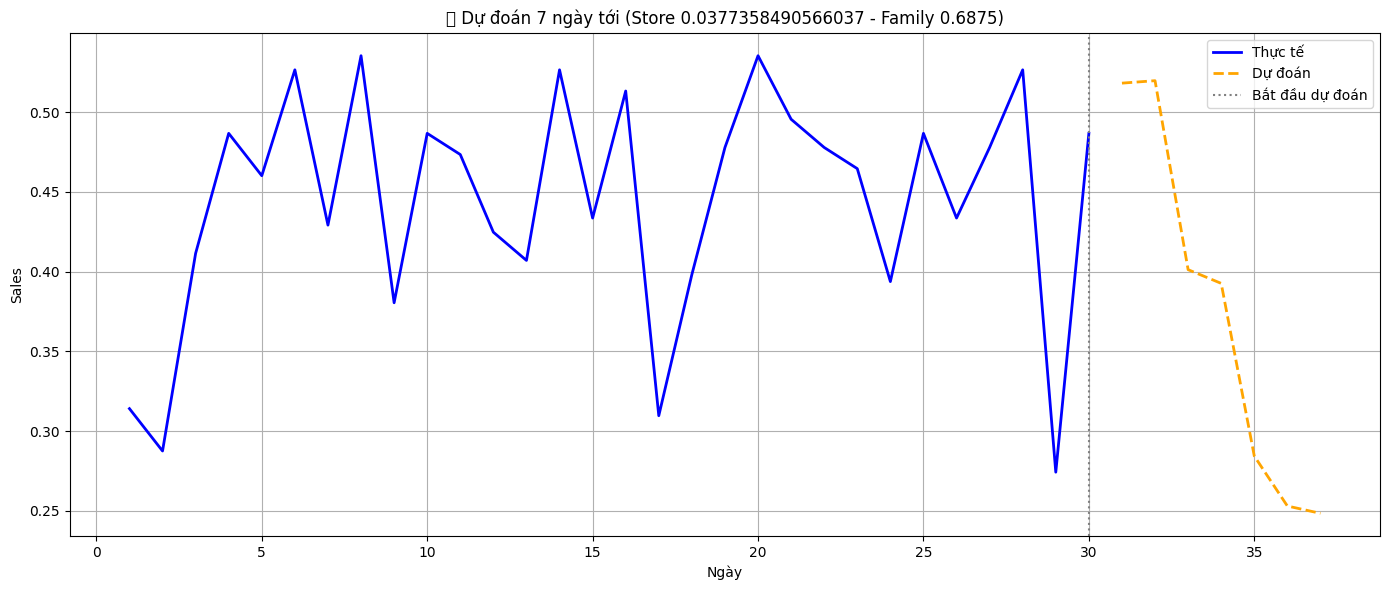


üìä Gi√° tr·ªã th·ª±c t·∫ø (30 ng√†y g·∫ßn nh·∫•t):
[0.31 0.29 0.41 0.49 0.46 0.53 0.43 0.54 0.38 0.49 0.47 0.42 0.41 0.53
 0.43 0.51 0.31 0.4  0.48 0.54 0.5  0.48 0.46 0.39 0.49 0.43 0.48 0.53
 0.27 0.49]

üîÆ D·ª± ƒëo√°n doanh s·ªë 7 ng√†y t·ªõi:
Ng√†y +1: 0.52
Ng√†y +2: 0.52
Ng√†y +3: 0.40
Ng√†y +4: 0.39
Ng√†y +5: 0.28
Ng√†y +6: 0.25
Ng√†y +7: 0.25


In [3]:
import glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# === Configuration ===
csv_files = sorted(glob.glob("data_chunks_2GB/*.csv"))[:30]
timesteps = 20
batch_size = 64
input_size = 8
store_id = 0.0377358490566037
family_id = 0.6875

# === Fit MinMaxScaler globally on all data (first 100k rows) ===
df_raw = pd.read_csv(csv_files[0]).dropna()
feature_cols = ['onpromotion_scaled', 'year_scaled', 'month_sin', 'month_cos',
                'day_sin', 'day_cos', 'family_scaled', 'store_scaled']
target_col = 'sales_scaled'

scaler = MinMaxScaler().fit(df_raw[feature_cols])

# === Dataset ===
class ChunkedTimeSeriesDataset(Dataset):
    def __init__(self, csv_files, timesteps, feature_cols, target_col, scaler, store_id, family_id):
        self.csv_files = csv_files
        self.timesteps = timesteps
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.buffer = []
        self.file_idx = 0
        self.chunk_iter = None
        self.scaler = scaler
        self.store_id = store_id
        self.family_id = family_id
        self._load_next_chunk()

    def _load_next_chunk(self):
        while self.file_idx < len(self.csv_files):
            file = self.csv_files[self.file_idx]
            self.chunk_iter = pd.read_csv(file, chunksize=100_000)
            self.file_idx += 1
            try:
                chunk = next(self.chunk_iter).dropna()
                chunk = chunk[(chunk['store_scaled'] == self.store_id) &
                              (chunk['family_scaled'] == self.family_id)]
                if chunk.empty:
                    continue
                scaled_features = self.scaler.transform(chunk[self.feature_cols])
                targets = chunk[self.target_col].values.reshape(-1, 1)
                self.buffer = np.hstack((targets, scaled_features)).tolist()
            except StopIteration:
                continue

    def __len__(self):
        return int(1e5)

    def __getitem__(self, idx):
        while len(self.buffer) < self.timesteps + 1:
            self._load_next_chunk()
            if len(self.buffer) < self.timesteps + 1:
                return self.__getitem__(idx + 1)

        start = np.random.randint(0, len(self.buffer) - self.timesteps - 1)
        window = np.array(self.buffer[start:start + self.timesteps + 1])
        return torch.tensor(window[:-1, 1:], dtype=torch.float32), torch.tensor(window[-1, 0], dtype=torch.float32)

# === GRU Model ===
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

# === Training Preparation ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = ChunkedTimeSeriesDataset(csv_files, timesteps, feature_cols, target_col,
                                    scaler, store_id, family_id)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

model = GRUModel(input_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# === Train ===
for epoch in range(10):
    model.train()
    total_loss = 0
    for i, (X, y) in enumerate(loader):
        X, y = X.to(device), y.to(device).unsqueeze(1)
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if i >= 300:
            break
    print(f"Epoch {epoch + 1}/10 - Avg Loss: {total_loss / 100:.4f}")

torch.save(model.state_dict(), f"gru_model_store{store_id}_family{family_id}.pth")

# === Evaluation ===
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for i, (X, y) in enumerate(loader):
        X, y = X.to(device), y.to(device)
        outputs = model(X).squeeze()
        y_true.extend(y.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())
        if i >= 300:
            break

# === Rescale to original sales ===
y_true, y_pred = np.array(y_true), np.array(y_pred)
min_y, scale_y = scaler.min_[0], scaler.scale_[0]
y_pred = y_pred * scale_y + min_y
y_true = y_true * scale_y + min_y

# === Metrics ===
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mse)

print("\nüìä Evaluation Metrics:")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R¬≤   = {r2:.4f}")

# === Visualization ===
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='True', color='blue', linewidth=2)
plt.plot(y_pred, label='Predicted', color='orange', linestyle='--', linewidth=2)
plt.title(f'Store {store_id} - Family {family_id} Prediction vs True')
plt.xlabel('Time Step')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

sns.histplot(y_true, kde=True)
plt.title(f"Target Distribution for Store {store_id} - Family {family_id}")
plt.show()

# === Multi-step forecast: D·ª± ƒëo√°n 7 ng√†y t·ªõi ===
forecast_steps = 7
initial_sequence = []

# L·∫•y chu·ªói 20 b∆∞·ªõc g·∫ßn nh·∫•t ƒë·ªÉ b·∫Øt ƒë·∫ßu d·ª± ƒëo√°n
for i in range(len(dataset.buffer) - timesteps, len(dataset.buffer)):
    initial_sequence.append(dataset.buffer[i][1:])  # ch·ªâ l·∫•y input features (b·ªè target)

input_seq = torch.tensor([initial_sequence], dtype=torch.float32).to(device)  # shape [1, 20, 8]

multi_preds = []
model.eval()
with torch.no_grad():
    for step in range(forecast_steps):
        pred = model(input_seq).squeeze().cpu().item()
        multi_preds.append(pred)

        # D√πng d√≤ng cu·ªëi l√†m feature gi·∫£ ƒë·ªãnh cho b∆∞·ªõc ti·∫øp theo
        last_known_features = input_seq[0, -1, :].cpu().numpy()
        new_row = last_known_features.copy()  # b·∫°n c√≥ th·ªÉ s·ª≠a logic n√†y n·∫øu c√≥ th√¥ng tin ng√†y/th√°ng th·∫≠t
        input_seq = input_seq.cpu().numpy()
        input_seq = np.append(input_seq[0], [new_row], axis=0)[-timesteps:]
        input_seq = torch.tensor([input_seq], dtype=torch.float32).to(device)

# === Rescale multi-step prediction ===
multi_preds = np.array(multi_preds)
multi_preds_rescaled = multi_preds * scale_y + min_y

# === Plot multi-step forecast ===
plt.figure(figsize=(10, 5))
plt.plot(range(1, forecast_steps + 1), multi_preds_rescaled, marker='o', linestyle='--', color='green')
plt.title(f"üìà D·ª± ƒëo√°n doanh s·ªë 7 ng√†y t·ªõi (Store {store_id} - Family {family_id})")
plt.xlabel("Ng√†y t∆∞∆°ng lai")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nüîÆ D·ª± ƒëo√°n 7 ng√†y t·ªõi:")
for i, val in enumerate(multi_preds_rescaled, 1):
    print(f"Ng√†y +{i}: {val:.2f}")
# === Multi-step forecast: D·ª± ƒëo√°n 7 ng√†y t·ªõi ===
forecast_steps = 7
initial_sequence = []

# L·∫•y 20 b∆∞·ªõc g·∫ßn nh·∫•t t·ª´ buffer (b·ªè target, ch·ªâ l·∫•y feature input)
for i in range(len(dataset.buffer) - timesteps, len(dataset.buffer)):
    initial_sequence.append(dataset.buffer[i][1:])  # ch·ªâ l·∫•y input features

input_seq = torch.tensor([initial_sequence], dtype=torch.float32).to(device)

multi_preds = []
model.eval()
with torch.no_grad():
    for step in range(forecast_steps):
        pred = model(input_seq).squeeze().cpu().item()
        multi_preds.append(pred)

        # Gh√©p gi√° tr·ªã d·ª± ƒëo√°n v√†o l√†m b∆∞·ªõc k·∫ø ti·∫øp (autoregressive)
        last_known_features = input_seq[0, -1, :].cpu().numpy()
        new_row = last_known_features.copy()
        # C·∫≠p nh·∫≠t chu·ªói input: th√™m d√≤ng m·ªõi v√† c·∫Øt gi·ªØ l·∫°i 20 b∆∞·ªõc
        input_seq = input_seq.cpu().numpy()
        input_seq = np.append(input_seq[0], [new_row], axis=0)[-timesteps:]
        input_seq = torch.tensor([input_seq], dtype=torch.float32).to(device)

# === Rescale d·ª± ƒëo√°n 7 ng√†y t·ªõi v·ªÅ sales g·ªëc ===
multi_preds = np.array(multi_preds)
multi_preds_rescaled = multi_preds * scale_y + min_y

# === L·∫•y 30 ng√†y th·ª±c t·∫ø g·∫ßn nh·∫•t t·ª´ buffer ===
true_last_30 = [row[0] for row in dataset.buffer[-30:]]  # target ƒë√£ scale
true_last_30 = np.array(true_last_30) * scale_y + min_y  # rescale

# === Gh√©p th·ª±c t·∫ø + d·ª± ƒëo√°n
combined = np.concatenate([true_last_30, multi_preds_rescaled])
steps = np.arange(1, len(combined) + 1)

# === Visualization: 30 ng√†y th·ª±c t·∫ø + 7 ng√†y d·ª± ƒëo√°n
plt.figure(figsize=(14, 6))
plt.plot(steps[:30], true_last_30, label="Th·ª±c t·∫ø", color="blue", linewidth=2)
plt.plot(steps[30:], multi_preds_rescaled, label="D·ª± ƒëo√°n", color="orange", linestyle="--", linewidth=2)
plt.axvline(x=30, color='gray', linestyle=':', label='B·∫Øt ƒë·∫ßu d·ª± ƒëo√°n')
plt.title(f"üìà D·ª± ƒëo√°n 7 ng√†y t·ªõi (Store {store_id} - Family {family_id})")
plt.xlabel("Ng√†y")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === In chi ti·∫øt
print("\nüìä Gi√° tr·ªã th·ª±c t·∫ø (30 ng√†y g·∫ßn nh·∫•t):")
print(true_last_30.round(2))

print("\nüîÆ D·ª± ƒëo√°n doanh s·ªë 7 ng√†y t·ªõi:")
for i, val in enumerate(multi_preds_rescaled, 1):
    print(f"Ng√†y +{i}: {val:.2f}")